- Import necessary packages.

In [1]:
import torch
import json
import gc
import matplotlib.pyplot as plt
import numpy as np
import lightning.pytorch as pl
import wandb
import transformers as tr

from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import List, Dict

- Setup necessary paths.

In [2]:
# Paths to the dataset
PATH_ROOT = Path(r'C:\Caesar\Machine_Learning\projects\my_cityscapes_scripts\subset')
TRAIN_ANNFILE = PATH_ROOT / 'annotations' / 'cityscapes_instances_train.json'
VAL_ANNFILE = PATH_ROOT / 'annotations' / 'cityscapes_instances_val.json'
TEST_ANNFILE = PATH_ROOT / 'annotations' / 'cityscapes_instances_test.json'

# Model artifact from which to start training
ARTIFACT_OR_NAME = 'suciucezar07/detr/model-uixu86xj:v2'

# Training hyperparameters
CONFIG = {
    'max_epochs': 10,
    'batch_size': 1,
    'num_workers': 0,
    'lr': 1e-4,
    'lr_backbone': 1e-5,
    'weight_decay': 1e-4,
    'unfreeze_epoch': 3,
    'overfit_batches': 1
}

- Utility class for Cityscapes in COCO Detection format.

In [3]:
class CityscapesDetectionAPI:

    def __init__(self, root: Path, annFile: Path):
        self.root = root
        self.annFile = annFile

        if not self.annFile.exists():
            raise FileNotFoundError(f'Annotation file not found at {self.annFile}.')

        print('loading annotations into memory...')
        with open(self.annFile, 'r') as f:
            self.annotations = json.load(f)
        print('done!')
        
        print('creating index...')
        self.categories = self.annotations['categories']
        for cat in self.categories: 
            cat['hasInstances'] = bool(cat['hasInstances'])
        self.images = self.annotations['images']
        self.annotations = self.annotations['annotations']
        self.image_ids = [img['id'] for img in self.images]
        print('index created!')
    
    def loadAnn(self, image_id: int):
        return [ann for ann in self.annotations if ann['image_id'] == image_id]

    def loadImgs(self, image_ids: List[int] | int):
        if isinstance(image_ids, int): 
            image_ids = [image_ids]
        return [Image.open(self.root / img['file_name']) for img 
                in list(filter(lambda img: img['id'] in image_ids, self.images))]
    
    def getImageIds(self):
        return self.image_ids
    
    def getCategoryById(self, category_id):
        return next((cat for cat in self.categories if cat['id'] == category_id), None)

    def __getitem__(self, image_id):
        return self.loadImgs(image_id)[0], self.loadAnn(image_id)

In [4]:
cityscapesAPI = CityscapesDetectionAPI(root=PATH_ROOT, annFile=TRAIN_ANNFILE)

loading annotations into memory...
done!
creating index...
index created!


In [5]:
cityscapesAPI.categories

[{'id': 0, 'name': 'road', 'supercategory': 'flat', 'hasInstances': False},
 {'id': 1, 'name': 'sidewalk', 'supercategory': 'flat', 'hasInstances': False},
 {'id': 2,
  'name': 'building',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 3,
  'name': 'wall',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 4,
  'name': 'fence',
  'supercategory': 'construction',
  'hasInstances': False},
 {'id': 5, 'name': 'pole', 'supercategory': 'object', 'hasInstances': False},
 {'id': 6,
  'name': 'traffic light',
  'supercategory': 'object',
  'hasInstances': False},
 {'id': 7,
  'name': 'traffic sign',
  'supercategory': 'object',
  'hasInstances': False},
 {'id': 8,
  'name': 'vegetation',
  'supercategory': 'nature',
  'hasInstances': False},
 {'id': 9,
  'name': 'terrain',
  'supercategory': 'nature',
  'hasInstances': False},
 {'id': 10, 'name': 'sky', 'supercategory': 'sky', 'hasInstances': False},
 {'id': 11, 'name': 'person', 'supercategory': 'human'

- Define `torch.utils.data.Dataset` object. 
- Return a sample in the format expected by the DETR model if processor is given. Otherwise it will return the loaded image and the corresponding annotation.

In [6]:
class CityscapesDetectionDataset(Dataset):
    
    def __init__(self, cityscapesAPI: CityscapesDetectionAPI, processor=None):
        self.cityscapesAPI = cityscapesAPI
        self.processor = processor

        self.image_ids = self.cityscapesAPI.getImageIds()

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img, target = self.cityscapesAPI[image_id]
        
        # -------------------------------------------------------
        # DATA AUGMENTATION
        # -------------------------------------------------------

        if self.processor is not None:
            target = {'image_id': image_id, 'annotations': target}
            encoding = self.processor(images=img, annotations=target, return_tensors="pt")

            pixel_values = encoding["pixel_values"].squeeze()
            target = encoding["labels"][0]

            return pixel_values, target

        return img, target

- Take a look at the COCO Detection format

In [7]:
val_dataset = CityscapesDetectionDataset(cityscapesAPI)

In [8]:
image, ann = val_dataset[0]

In [9]:
ann[0].keys()

dict_keys(['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd'])

- Function used to show the annotation on a given image.

In [10]:
def showAnn(image: Image, ann: List[Dict[str, any]], include_noInstances: bool = False):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)

    for instance in ann:
        category = cityscapesAPI.getCategoryById(instance['category_id'])
        # skip non-instance categories if include_noInstances is False
        if not category['hasInstances'] and not include_noInstances:
            continue

        # pick random color for the box
        color = list(np.random.random(size=3))
        
        # draw the box
        x, y, w, h = instance['bbox']
        ax.add_patch(plt.Rectangle((x, y), w, h, fill=False, color=color, linewidth=2))
        ax.text(x, y, category['name'], fontsize=7, bbox=dict(facecolor='yellow', alpha=0.5))
        
    plt.axis('off')
    plt.show()

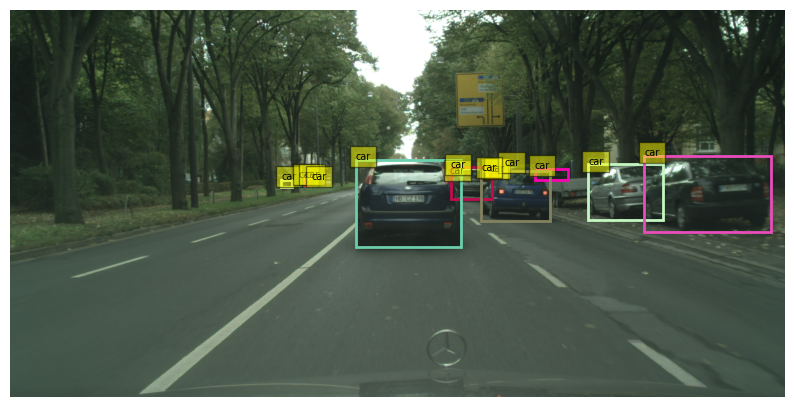

In [11]:
showAnn(image, ann, include_noInstances=False)

- Load Image Processor for detection from Huggingface library

In [12]:
processor = tr.DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [13]:
def collate_fn(batch):
    pixel_values, labels = list(zip(*batch))
    encoding = processor.pad(pixel_values, return_tensors="pt")
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

In [14]:
class CityscapesDetectionDataModule(pl.LightningDataModule):

    def __init__(self, root: Path, annFiles: Dict[str, Path]):
        super().__init__()

        self.root = root
        self.cityscapesAPIs = {
            split: CityscapesDetectionAPI(root=self.root, annFile=annFile)
            for split, annFile in annFiles.items()
            if annFile is not None
        }
        self.datasets = {}
        
        self.processor = processor

        # metadata related to the dataset
        self.categories = self.cityscapesAPIs['train'].categories
        self.MAX_CLASS_ID = max([cat['id'] for cat in self.categories])

    def setup(self, stage):
        if stage == 'fit':
            for split in ['train', 'val']:
                self.datasets[split] = CityscapesDetectionDataset(
                    cityscapesAPI=self.cityscapesAPIs[split], processor=self.processor)
            
        if stage == 'test':
            self.datasets['test'] = CityscapesDetectionDataset(
                cityscapesAPI=self.cityscapesAPIs['test'], processor=self.processor)
    
    def train_dataloader(self):
        return DataLoader(
            self.datasets['train'], 
            batch_size=CONFIG['batch_size'], 
            num_workers=CONFIG['num_workers'],
            collate_fn=collate_fn,
            shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(
            self.datasets['val'], 
            batch_size=CONFIG['batch_size'], 
            num_workers=CONFIG['num_workers'],
            collate_fn=collate_fn)
    
    def test_dataloader(self):
        return DataLoader(
            self.datasets['val'], 
            batch_size=CONFIG['batch_size'], 
            num_workers=CONFIG['num_workers'])

In [15]:
annFiles = {
    'train': TRAIN_ANNFILE,
    'val': VAL_ANNFILE,
    'test': TEST_ANNFILE

}

datamodule = CityscapesDetectionDataModule(root=PATH_ROOT, annFiles=annFiles)
datamodule.setup('fit')

loading annotations into memory...
done!
creating index...
index created!
loading annotations into memory...
done!
creating index...
index created!
loading annotations into memory...
done!
creating index...
index created!


- Explore the batch's format DETR expects for Detection

In [16]:
batch = next(iter(datamodule.train_dataloader()))

In [17]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [18]:
batch['pixel_values'].shape, batch['pixel_mask'].shape

(torch.Size([1, 3, 666, 1332]), torch.Size([1, 666, 1332]))

In [19]:
batch['labels'][0].keys()

dict_keys(['size', 'image_id', 'class_labels', 'boxes', 'area', 'iscrowd', 'orig_size'])

- Create a callback which will unfreeze the rest of the model at the beginning of a given epoch.

In [20]:
class UnfreezeCallback(pl.Callback):

    def __init__(self, unfreeze_epoch, lr, lr_backbone, weight_decay):
        self.unfreeze_epoch = unfreeze_epoch
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def on_train_epoch_start(self, trainer, pl_module):
        if trainer.current_epoch == self.unfreeze_epoch:
            # unfreeze the entire detection module
            pl_module.unfreeze()
        
            # update the optimizer
            param_dicts = [
                {"params": [p for n, p in trainer.model.named_parameters() if "backbone" not in n and p.requires_grad]},
                {
                    "params": [p for n, p in trainer.model.named_parameters() if "backbone" in n and p.requires_grad],
                    "lr": self.lr_backbone,
                },
            ]
            optimizer = torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

            trainer.optimizers = [optimizer]

            print(f"Unfroze the model at epoch {self.unfreeze_epoch}.")

In [21]:
class DetectionModel(pl.LightningModule):

    def __init__(self, lr=1e-4):
        super(DetectionModel, self).__init__()
        self.lr = lr
        self.detr = tr.DetrForObjectDetection.from_pretrained(
            "facebook/detr-resnet-50", 
            num_labels=datamodule.MAX_CLASS_ID + 1, 
            ignore_mismatched_sizes=True)

        # freeze all modules except the classification head
        self.detr.model.requires_grad_(False)
        self.detr.bbox_predictor.requires_grad_(False)
        self.detr.class_labels_classifier.requires_grad_(True)
        
        self.save_hyperparameters()

    def forward(self, pixel_values, pixel_mask, labels=None):
        return self.detr(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

    def training_step(self, batch, batch_idx):
        outputs = self.detr(**batch)

        self.log('train/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        for k, v in outputs['loss_dict'].items(): 
            self.log(f'train/{k}', v, on_epoch=True)
            
        return outputs['loss']

    def validation_step(self, batch, batch_idx):
        outputs = self.detr(**batch)

        self.log('val/loss', outputs['loss'], on_step=True, on_epoch=True, prog_bar=True)
        for k, v in outputs['loss_dict'].items(): 
            self.log(f'val/{k}', v, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.detr.parameters(), lr=self.lr)

    def unfreeze(self):
        for param in self.detr.parameters(): 
            param.requires_grad = True

In [22]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: suciucezar07. Use `wandb login --relogin` to force relogin


True

In [24]:
wandb_logger = pl.loggers.WandbLogger(project='detr', log_model='all')

In [25]:
wandb_logger.experiment.config.update(CONFIG)

In [27]:
detr_pl = DetectionModel(lr=CONFIG['lr'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [28]:
wandb_logger.watch(detr_pl, log='all')

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [29]:
unfreeze_callback = UnfreezeCallback(
    unfreeze_epoch=CONFIG['unfreeze_epoch'], 
    lr=CONFIG['lr'], 
    lr_backbone=CONFIG['lr_backbone'], 
    weight_decay=CONFIG['weight_decay'])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val/loss', mode='min')

trainer = pl.Trainer(
    max_epochs=CONFIG['max_epochs'], 
    accelerator="auto", 
    logger=wandb_logger,
    gradient_clip_val=0.1, 
    callbacks=[unfreeze_callback, checkpoint_callback],
    log_every_n_steps=1,
    overfit_batches=CONFIG['overfit_batches'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.


In [30]:
torch.cuda.empty_cache()
gc.collect()

80

In [31]:
if ARTIFACT_OR_NAME is not None:
    artifact_dir = wandb_logger.download_artifact(ARTIFACT_OR_NAME)
    ckpt_path = Path(artifact_dir) / 'model.ckpt'
    wandb_logger.experiment.config.update({'artifact': ARTIFACT_OR_NAME})
else:
    ckpt_path = None

wandb: Downloading large artifact model-uixu86xj:v2, 158.98MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


In [32]:
trainer.fit(detr_pl, datamodule=datamodule, ckpt_path=ckpt_path)

You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at c:\Caesar\Machine_Learning\projects\detr\artifacts\model-uixu86xj-v2\model.ckpt


c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:361: The dirpath has changed from '.\\detr\\uixu86xj\\checkpoints' to '.\\detr\\gndibzg4\\checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type                   | Params
------------------------------------------------
0 | detr | DetrForObjectDetection | 41.5 M
------------------------------------------------
5.1 K     Trainable params
41.5 M    Non-trainable params
41.5 M    Total params
166.025   Total estimated model params size (MB)
Restored all states from the checkpoint at c:\Caesar\Machine_Learning\projects\detr\artifacts\model-uixu86xj-v2\model.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:268: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
c:\Users\snovi\anaconda3\envs\pytorch_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers 

Training: |          | 0/? [00:00<?, ?it/s]

Unfroze the model at epoch 3.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [33]:
wandb.finish()

epoch,▁▁▁▂▂▂▃▃▃▅▅▅▆▆▆▇▇▇███
train/cardinality_error_epoch,█▃▄▁▁▂▁
train/cardinality_error_step,█▃▄▁▁▂▁
train/loss_bbox_epoch,▄▁▃▁▂▅█
train/loss_bbox_step,▄▁▃▁▂▅█
train/loss_ce_epoch,█▇▅▄▃▂▁
train/loss_ce_step,█▇▅▄▃▂▁
train/loss_epoch,▂▆▇▁▁█▂
train/loss_giou_epoch,▁▄▅▄▅█▆
train/loss_giou_step,▁▄▅▄▅█▆
train/loss_step,▂▆▇▁▁█▂


- Inference + Visualization

In [34]:
inputs = next(iter(datamodule.val_dataloader()))

In [35]:
with torch.no_grad():
    outputs = detr_pl(inputs['pixel_values'], inputs['pixel_mask'])

In [36]:
decoded_outputs = processor.post_process_object_detection(
    outputs, threshold=0.0, target_sizes=[t['orig_size'] for t in inputs['labels']])

images = datamodule.cityscapesAPIs['val'].loadImgs([label['image_id'] for label in inputs['labels']])

In [37]:
def drawDetections(image, detections, include_noInstances: bool = False):
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    for score, category, (xmin, ymin, xmax, ymax) in detections:
        if category['hasInstances'] == False and include_noInstances == False:
            continue
        
        name, color = category['name'], list(np.random.random(size=3))
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=color, linewidth=2))
        text = f'{name} {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, color='white')
        
    plt.axis('off')
    plt.show()

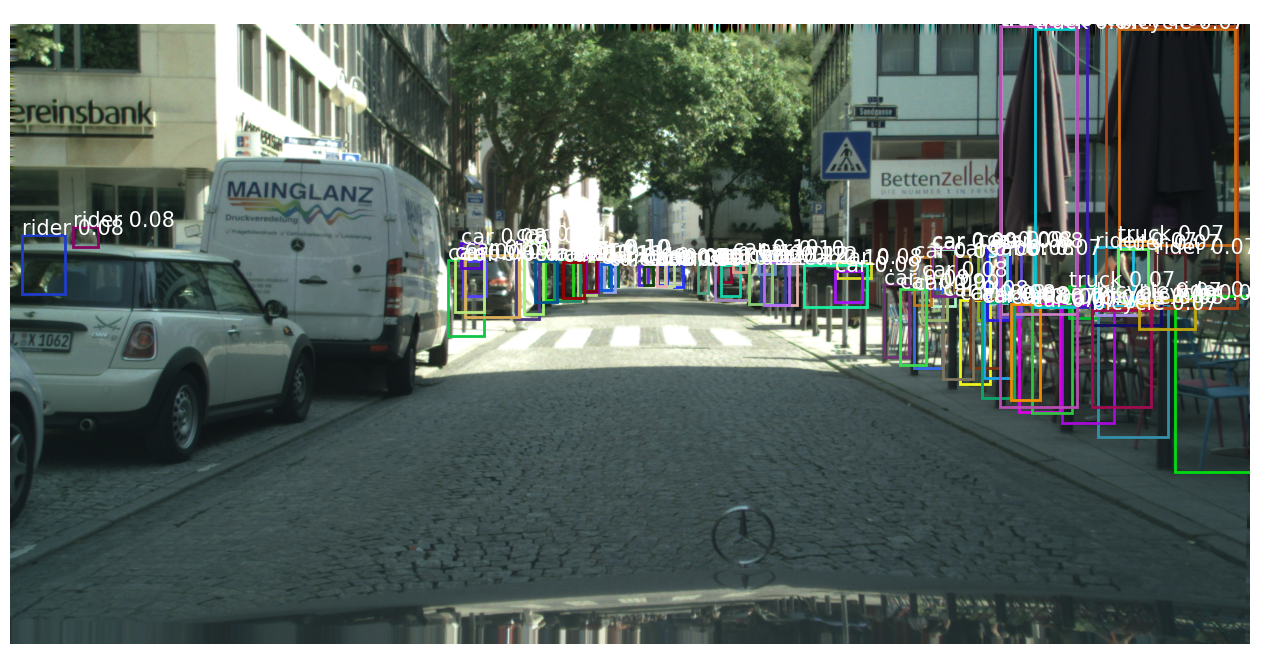

In [38]:
image, output = next(iter(zip(images, decoded_outputs)))
NO_OBJECT_ID = datamodule.MAX_CLASS_ID + 1

detections = list(zip(output['scores'].tolist(), output['labels'].tolist(), output['boxes'].tolist()))
detections = list(filter(lambda x: x[1] != NO_OBJECT_ID, detections))

categories = [datamodule.cityscapesAPIs['val'].getCategoryById(d[1]) for d in detections]

scores, labels, boxes = list(zip(*detections))
detections = list(zip(scores, categories, boxes))

drawDetections(image, detections, include_noInstances=False)